In [15]:
import ast
import swifter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gender_guesser.detector as gg
from names_dataset import NameDataset

In [16]:
df = pd.read_csv('massive_Crossreff_pull.csv')

NCSES = pd.read_csv('NCSES_Data.csv') # Research doctorate recipients, by historical major field of doctorate and sex: 2017–22

with open('subjects_list_crossref.txt', 'r') as file:
    content = file.read()
    subjects = ast.literal_eval(content)

In [17]:
life_sciences = ['Molecular Medicine', 'Physiology (medical)', 'Hepatology', 'Embryology', 'Animal Science and Zoology',
                 'Biological Psychiatry', 'Biochemistry', 'Infectious Diseases', 'Aquatic Science', 'Biochemistry (medical)',
                 'Genetics', 'Neurology', 'Hematology', 'Health, Toxicology and Mutagenesis', 'Developmental Biology',
                 'Biomedical Engineering', 'Molecular Biology', 'Behavioral Neuroscience', 'Biophysics', 'Rheumatology', 'Anatomy',
                 'Endocrinology', 'Cell Biology', 'Immunology and Allergy', 'Genetics (clinical)', 'Pediatrics, Perinatology and Child Health',
                 'Oncology', 'Biomaterials', 'Cardiology and Cardiovascular Medicine', 'Immunology', 'Cancer Research']

physical_sciences_and_earth_sciences = ['Discrete Mathematics and Combinatorics', 'Atmospheric Science', 'General Physics and Astronomy',
                                        'Physical and Theoretical Chemistry', 'General Chemistry', 'Analytical Chemistry', 'Statistical and Nonlinear Physics',
                                        'Condensed Matter Physics', 'Spectroscopy', 'Nuclear and High Energy Physics', 'Atomic and Molecular Physics, and Optics',
                                        'Oceanography', 'Soil Science', 'Global and Planetary Change', 'General Environmental Science', 'Pollution', 'Water Science and Technology',
                                        'Ecology', 'Environmental Chemistry', 'Ecology, Evolution, Behavior and Systematics']

mathematics_and_computer_sciences = ['Computational Theory and Mathematics', 'Information Systems and Management', 'Management Information Systems',
                                     'Computer Networks and Communications', 'Theoretical Computer Science', 'Health Informatics', 'Software', 'Computer Science (miscellaneous)',
                                     'General Computer Science']

psychology_and_social_sciences = ['General Psychology', 'Experimental and Cognitive Psychology', 'Geography, Planning and Development', 'Sociology and Political Science',
                                  'Political Science and International Relations', 'General Social Sciences', 'Anthropology', 'Demography']

engineering = ['Surfaces and Interfaces', 'Energy Engineering and Power Technology', 'Control and Systems Engineering', 'Waste Management and Disposal',
               'Modeling and Simulation', 'Signal Processing', 'Mechanical Engineering', 'Environmental Engineering', 'Software', 'Information Systems',
               'Electrical and Electronic Engineering', 'Aerospace Engineering', 'Computer Science Applications', 'Ocean Engineering', 'Computational Mechanics',
               'Nuclear Energy and Engineering', 'Electronic, Optical and Magnetic Materials', 'Instrumentation']

education = []  # Empty because none of the crossreff subjects fit in here

humanities_and_arts = ['General Arts and Humanities', 'Visual Arts and Performing Arts', 'History and Philosophy of Science', 'Cultural Studies',
                       'Philosophy', 'Classics', 'Communication', 'Religious studies', 'Museology', 'Music', 'History']

others = [subject for subject in subjects if subject not in life_sciences + physical_sciences_and_earth_sciences + mathematics_and_computer_sciences +
          psychology_and_social_sciences + engineering + education + humanities_and_arts]

# Categorized subjects into the new buckets
categorized_subjects = {
    'Life Sciences': life_sciences,
    'Physical and Earth Sciences': physical_sciences_and_earth_sciences,
    'Mathematics and Computer Sciences': mathematics_and_computer_sciences,
    'Psychology and Social Sciences': psychology_and_social_sciences,
    'Engineering': engineering,
    'Education': education,
    'Humanities and Arts': humanities_and_arts,
    'Other': others
}

# Creating a reverse mapping from subject to category
subject_to_category = {}
for category, subjects_in_category in categorized_subjects.items():
    for subject in subjects_in_category:
        subject_to_category[subject] = category

# Mapping the subjects to their broader category
df['Topic'] = df['Subject'].map(subject_to_category)

# If there's any subject that wasn't categorized, you can fill NaN values with 'Other'
df['Topic'].fillna('Other', inplace=True)

In [18]:
# Identify articles with missing author names
missing_author_article_ids = df[df['Author First Name'].isna() | (df['Author First Name'].astype(str).str.strip() == '')]['Title'].unique()

# Print the number of articles and their titles removed
print(f"Number of articles removed: {len(missing_author_article_ids)}")
print(f"Names of articles removed: {', '.join(missing_author_article_ids)}")

# Filter out those articles
df_result = df[~df['Title'].isin(missing_author_article_ids)]

In [19]:
print(df.shape)
df.head()

(15528792, 12)


,DOI,Title,Container Title,Publisher,Publish Date,Author First Name,Author Last Name,Author Order,Referenced By,Year,Subject,Topic
0,10.4324/9781315177977-8,Technology innovation,Sports innovation management,Routledge,"[2017, 8, 23]",Vanessa,Ratten,1,0,2017,Management of Technology and Innovation,Other
1,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Mila,Galeitzke,1,1,2017,Management of Technology and Innovation,Other
2,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Erik,Steinhöfel,2,1,2017,Management of Technology and Innovation,Other
3,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Ronald,Orth,3,1,2017,Management of Technology and Innovation,Other
4,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Holger,Kohl,4,1,2017,Management of Technology and Innovation,Other


In [20]:
# Initialize gender_guesser Detector
detector = gg.Detector()

# Function to predict gender using gender_guesser
def predict_gender(name):
    if not isinstance(name, str) or not name.strip():
        return "X"
    first_name = name.split()[0]
    gg_guess = detector.get_gender(first_name)
    if gg_guess in ["male", "mostly_male"]:
        return "M"
    elif gg_guess in ["female", "mostly_female"]:
        return "F"
    else:
        return "X"

# Assuming df is your DataFrame with the column 'Author First Name'
df_result = df.copy()
df_result['Gender'] = df['Author First Name'].apply(predict_gender)

# Initialize names_dataset
m = NameDataset()

# Function to infer gender using names_dataset
def infer_gender_from_names_dataset(name):
    if not isinstance(name, str) or not name.strip():
        return "X"
    first_name = name.split()[0]
    gender_data = m.search(first_name)  # Adjusted this line
    if gender_data.get('gender') == 'male':
        return "M"
    elif gender_data.get('gender') == 'female':
        return "F"
    else:
        return "X"

# For rows with 'X' gender, apply names_dataset to infer gender
unknown_gender_indices = df_result[df_result['Gender'] == "X"].index
df_result.loc[unknown_gender_indices, 'Gender'] = df_result.loc[unknown_gender_indices, 'Author First Name'].apply(infer_gender_from_names_dataset)

Pandas Apply: 100%|██████████| 15528792/15528792 [00:26<00:00, 596235.89it/s]


In [21]:
df_result.head()

,DOI,Title,Container Title,Publisher,Publish Date,Author First Name,Author Last Name,Author Order,Referenced By,Year,Subject,Topic,Gender
0,10.4324/9781315177977-8,Technology innovation,Sports innovation management,Routledge,"[2017, 8, 23]",Vanessa,Ratten,1,0,2017,Management of Technology and Innovation,Other,F
1,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Mila,Galeitzke,1,1,2017,Management of Technology and Innovation,Other,F
2,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Erik,Steinhöfel,2,1,2017,Management of Technology and Innovation,Other,M
3,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Ronald,Orth,3,1,2017,Management of Technology and Innovation,Other,M
4,10.1142/s0219877017500286,Intellectual Capital-Driven Technology and Inn...,International Journal of Innovation and Techno...,World Scientific Pub Co Pte Lt,"[2017, 10]",Holger,Kohl,4,1,2017,Management of Technology and Innovation,Other,M


In [22]:
gender_counts = df_result['Gender'].value_counts()
gender_percentage = df_result['Gender'].value_counts(normalize=True) * 100

for gender, count in gender_counts.items():
    print(f"{gender}: {count} ({gender_percentage[gender]:.2f}%)")


X: 7218833 (46.49%)
M: 5322905 (34.28%)
F: 2987054 (19.24%)


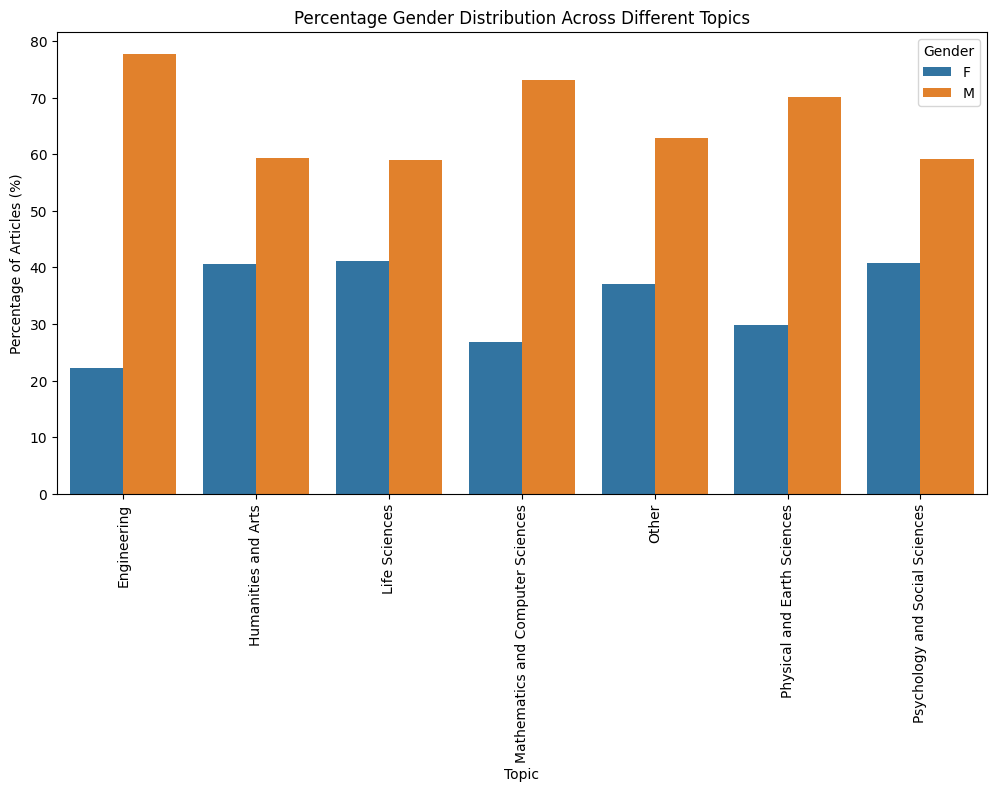

In [27]:
# Filter out rows with Topic as 'Other' and Gender as 'X'
filtered_df = df_result[(df_result['Topic'] != 'Others') & (df_result['Gender'] != 'X')]

# Compute the percentage distribution
topic_gender_distribution = filtered_df.groupby(['Topic', 'Gender']).size().unstack().fillna(0)
topic_gender_distribution_percentage = topic_gender_distribution.divide(topic_gender_distribution.sum(axis=1), axis=0) * 100

topic_gender_distribution_percentage.reset_index(inplace=True)
topic_gender_distribution_percentage = topic_gender_distribution_percentage.melt(id_vars='Topic', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(data=topic_gender_distribution_percentage, x='Topic', y='Percentage', hue='Gender')
plt.title('Percentage Gender Distribution Across Different Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage of Articles (%)')
plt.xticks(rotation=90)
plt.legend(title='Gender')
plt.show()


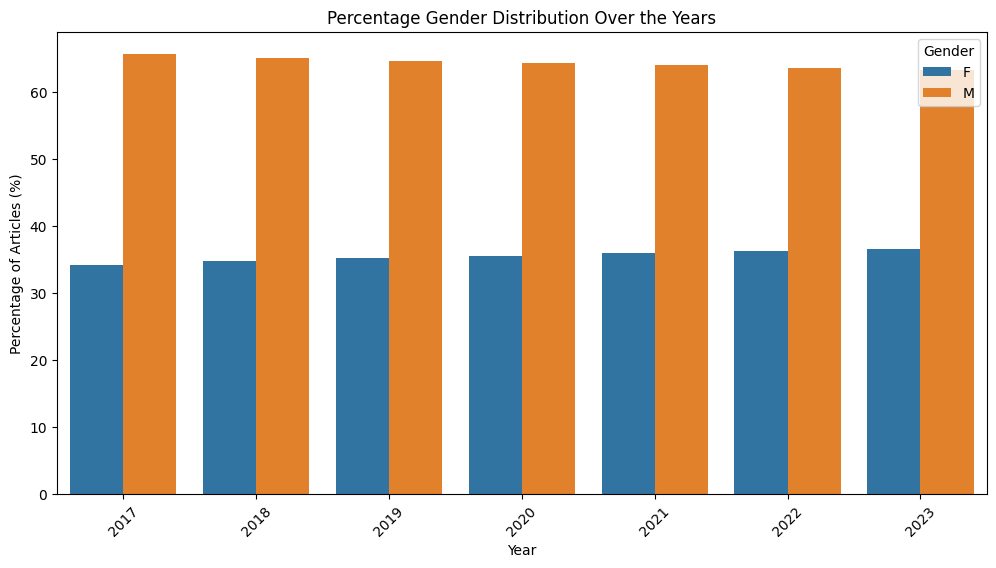

In [24]:
# Filter out rows with Gender as 'X'
filtered_df_year = df_result[df_result['Gender'] != 'X']

# Compute the percentage distribution
year_gender_distribution = filtered_df_year.groupby(['Year', 'Gender']).size().unstack().fillna(0)
year_gender_distribution_percentage = year_gender_distribution.divide(year_gender_distribution.sum(axis=1), axis=0) * 100

year_gender_distribution_percentage.reset_index(inplace=True)
year_gender_distribution_percentage = year_gender_distribution_percentage.melt(id_vars='Year', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.barplot(data=year_gender_distribution_percentage, x='Year', y='Percentage', hue='Gender')
plt.title('Percentage Gender Distribution Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage of Articles (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()


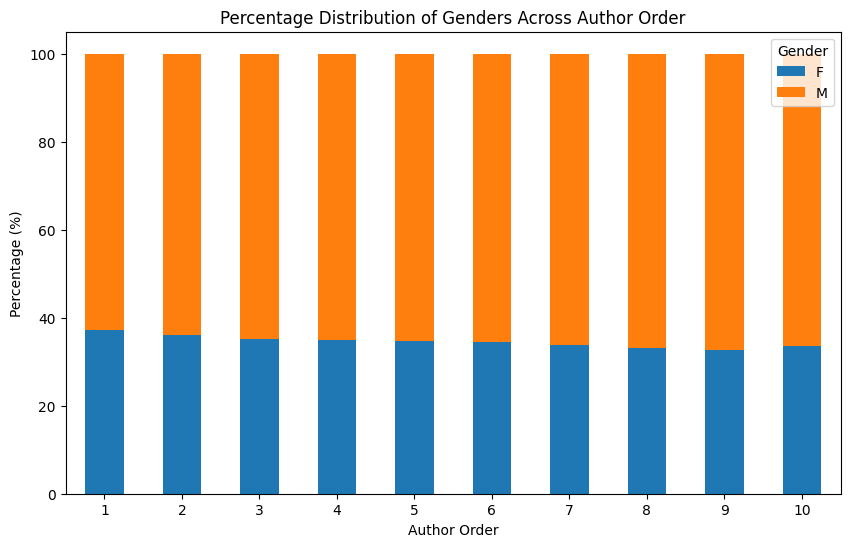

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for relevant genders and orders
filtered_df = df_result[(df_result['Gender'].isin(['M', 'F'])) & (df_result['Author Order'] <= 10)]

# Cross-tabulate to find counts of each gender for each author position
ctab = pd.crosstab(index=filtered_df['Author Order'], columns=filtered_df['Gender'], normalize='index') * 100

# Plot the result
ctab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage Distribution of Genders Across Author Order')
plt.ylabel('Percentage (%)')
plt.xlabel('Author Order')
plt.legend(title='Gender')
plt.xticks(rotation=0)  # Set the rotation for x-axis labels
plt.show()
